In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data
file_path = "/content/customer_data.xlsx"
customer_data = pd.read_excel(file_path)

# Handle missing values if any
numeric_columns = customer_data.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = customer_data.select_dtypes(include=['object']).columns

for column in numeric_columns:
    if customer_data[column].isnull().sum() > 0:
        customer_data[column].fillna(customer_data[column].mean(), inplace=True)

for column in categorical_columns:
    if customer_data[column].isnull().sum() > 0:
        customer_data[column].fillna(customer_data[column].mode()[0], inplace=True)

In [3]:
# Feature selection
numerical_features = [
    'age',
    'transaction_frequency',
    'customer_tenure',
    'total_transaction_volume',
    'weekend_transaction_ratio',
    'avg_daily_transactions',
    'customer_lifetime_value'
]

categorical_features = [
    'income_bracket',
    'education_level',
    'marital_status',
    'acquisition_channel',
    'preferred_transaction_type'
]

In [4]:
# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clusterer', KMeans(n_clusters=4, random_state=42))
])

In [5]:
# Prepare data for clustering
X = customer_data[numerical_features + categorical_features]

In [6]:
# Fit pipeline and predict clusters
customer_data['Cluster'] = pipeline.fit_predict(X)

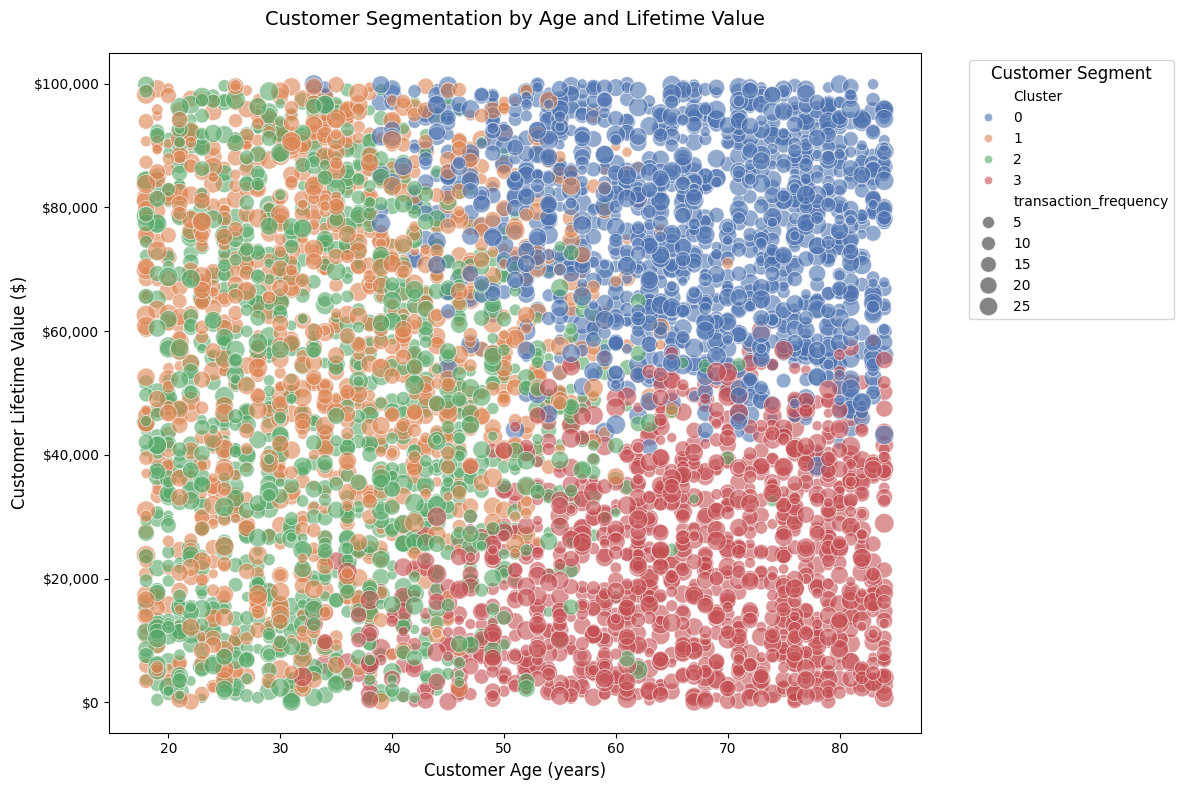

In [7]:
# Creating the visualizations

# 1. Age vs Customer Lifetime Value Scatter Plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=customer_data,
                         x='age',
                         y='customer_lifetime_value',
                         hue='Cluster',
                         size='transaction_frequency',
                         sizes=(50, 200),
                         alpha=0.6,
                         palette='deep')

plt.title('Customer Segmentation by Age and Lifetime Value', fontsize=14, pad=20)
plt.xlabel('Customer Age (years)', fontsize=12)
plt.ylabel('Customer Lifetime Value ($)', fontsize=12)
plt.legend(title='Customer Segment', title_fontsize=12, bbox_to_anchor=(1.05, 1))
# Format y-axis to show thousands
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])
plt.tight_layout()
plt.show()

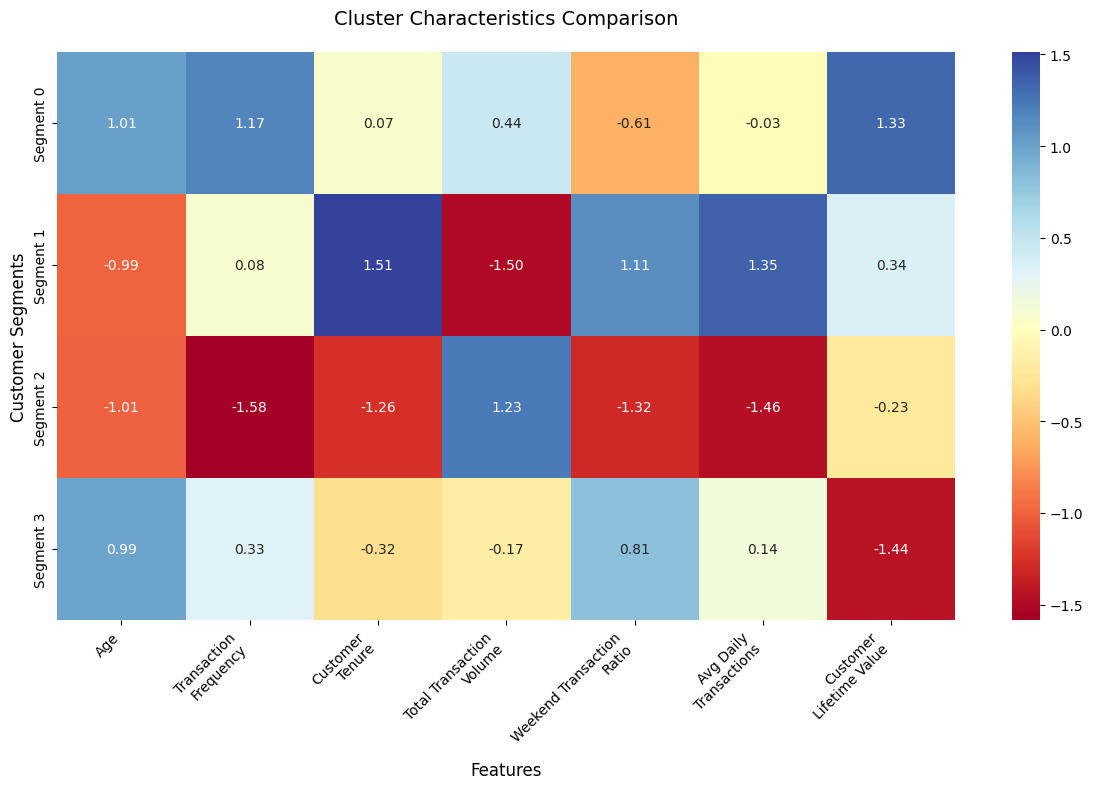

In [9]:
# 2. Feature Importance Heatmap
plt.figure(figsize=(12, 8))
# Calculate and plot correlation heatmap
cluster_means = customer_data.groupby('Cluster')[numerical_features].mean()
cluster_means_scaled = StandardScaler().fit_transform(cluster_means)

# Creating more readable labels
feature_labels = [
    'Age',
    'Transaction\nFrequency',
    'Customer\nTenure',
    'Total Transaction\nVolume',
    'Weekend Transaction\nRatio',
    'Avg Daily\nTransactions',
    'Customer\nLifetime Value'
]

sns.heatmap(cluster_means_scaled,
            annot=True,
            cmap='RdYlBu',
            center=0,
            fmt='.2f',
            xticklabels=feature_labels,
            yticklabels=[f'Segment {i}' for i in range(4)])

plt.title('Cluster Characteristics Comparison', fontsize=14, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Customer Segments', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


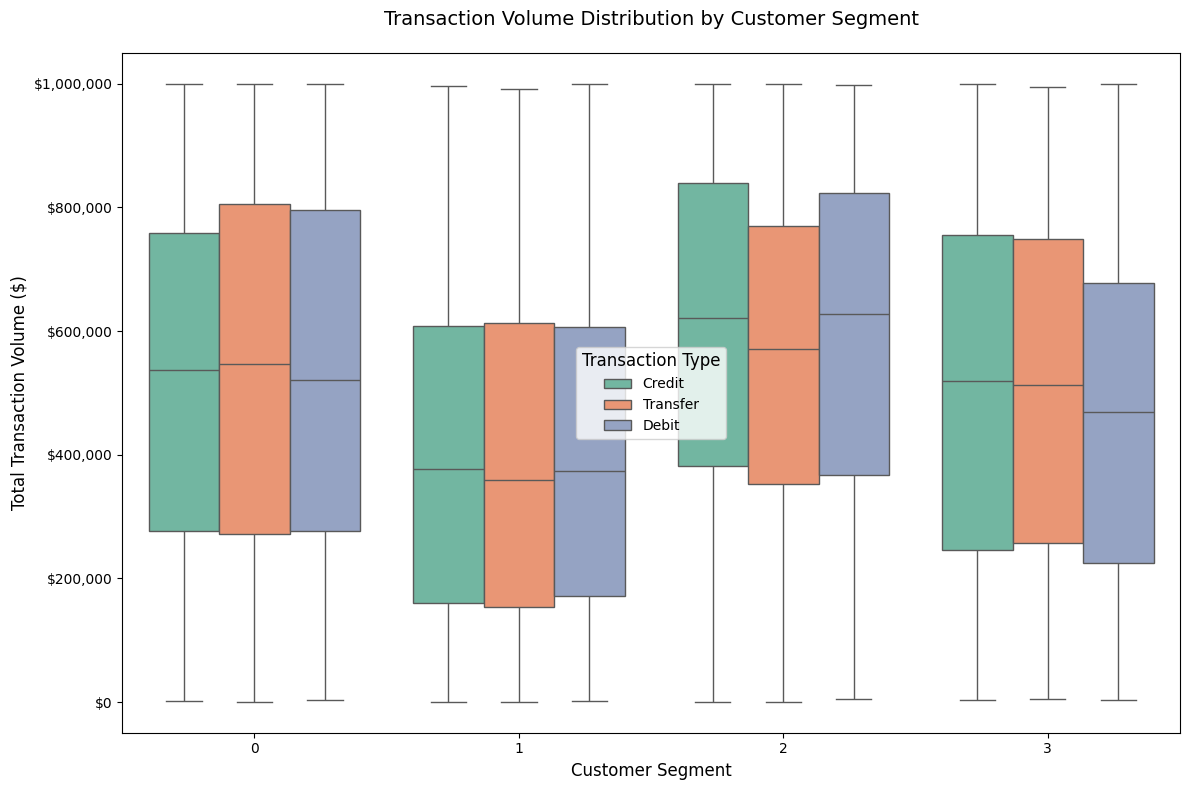

In [10]:
# 3. Transaction Patterns Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=customer_data,
           x='Cluster',
           y='total_transaction_volume',
           hue='preferred_transaction_type',
           palette='Set2')

plt.title('Transaction Volume Distribution by Customer Segment', fontsize=14, pad=20)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Total Transaction Volume ($)', fontsize=12)
plt.legend(title='Transaction Type', title_fontsize=12)
# Format y-axis to show thousands
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

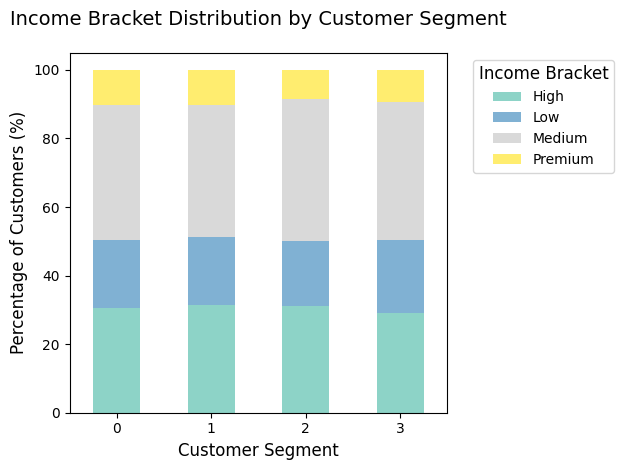

In [11]:
# 4. Income Distribution Stacked Bar Chart
plt.figure(figsize=(12, 8))
income_dist = pd.crosstab(customer_data['Cluster'],
                         customer_data['income_bracket'],
                         normalize='index') * 100

income_dist.plot(kind='bar',
                stacked=True,
                colormap='Set3')

plt.title('Income Bracket Distribution by Customer Segment', fontsize=14, pad=20)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Percentage of Customers (%)', fontsize=12)
plt.legend(title='Income Bracket', title_fontsize=12, bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

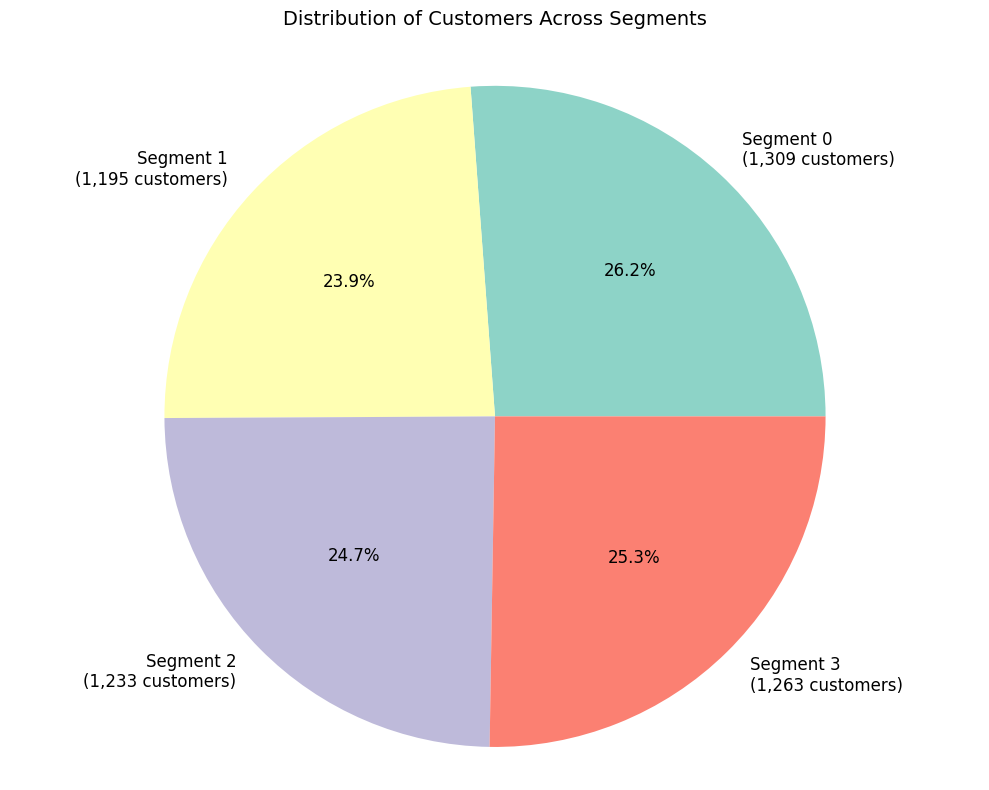

In [12]:
# 5. Segment Size Distribution
plt.figure(figsize=(10, 8))
sizes = customer_data['Cluster'].value_counts().sort_index()
plt.pie(sizes,
        labels=[f'Segment {i}\n({v:,} customers)' for i, v in sizes.items()],
        autopct='%1.1f%%',
        colors=sns.color_palette('Set3'),
        textprops={'fontsize': 12})
plt.title('Distribution of Customers Across Segments', fontsize=14, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [13]:
# Print summary statistics for each segment
print("\nDetailed Segment Profiles:")
for cluster in range(4):
    segment_data = customer_data[customer_data['Cluster'] == cluster]
    print(f"\nSegment {cluster}:")
    print("-" * 50)
    print(f"Size: {len(segment_data):,} customers ({len(segment_data)/len(customer_data)*100:.1f}%)")
    print(f"Average Age: {segment_data['age'].mean():.1f} years")
    print(f"Average Customer Lifetime Value: ${segment_data['customer_lifetime_value'].mean():,.2f}")
    print(f"Average Transaction Volume: ${segment_data['total_transaction_volume'].mean():,.2f}")
    print(f"Most Common Income Bracket: {segment_data['income_bracket'].mode()[0]}")
    print(f"Most Common Education Level: {segment_data['education_level'].mode()[0]}")


Detailed Segment Profiles:

Segment 0:
--------------------------------------------------
Size: 1,309 customers (26.2%)
Average Age: 66.4 years
Average Customer Lifetime Value: $76,671.86
Average Transaction Volume: $528,104.39
Most Common Income Bracket: Medium
Most Common Education Level: PhD

Segment 1:
--------------------------------------------------
Size: 1,195 customers (23.9%)
Average Age: 35.0 years
Average Customer Lifetime Value: $57,262.19
Average Transaction Volume: $405,190.97
Most Common Income Bracket: Medium
Most Common Education Level: Bachelor

Segment 2:
--------------------------------------------------
Size: 1,233 customers (24.7%)
Average Age: 34.9 years
Average Customer Lifetime Value: $45,897.22
Average Transaction Volume: $577,598.58
Most Common Income Bracket: Medium
Most Common Education Level: High School

Segment 3:
--------------------------------------------------
Size: 1,263 customers (25.3%)
Average Age: 66.0 years
Average Customer Lifetime Value: $2